In [1]:
# pandas and numpy for working with data
import pandas as pd 
import numpy as np

# seaborn and matplotlib for visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
daily_reports = pd.read_csv("../data/csse_covid_19_daily_reports_us.csv")
daily_reports['Date_Last_Update'] = pd.to_datetime(pd.to_datetime(daily_reports.loc[:,'Last_Update']).dt.date)

In [62]:
state_reports = {}
for state in ['California','Oregon','Nevada','New York','New Jersey']:
    state_reports[state] = daily_reports[daily_reports["Province_State"]==state]

In [38]:
state_reports['California'].head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,...,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate,Date_Last_Update
5,California,US,2021-01-02 05:30:44,36.1162,-119.6816,2365024,26363,NaN,2309915.0,6.0,...,33058311.0,NaN,1.125160,84000006.0,USA,83666.036710,NaN,NaN,NaN,2021-01-02
63,California,US,2021-01-03 05:30:33,36.1162,-119.6816,2415246,26551,NaN,2362015.0,6.0,...,33391442.0,NaN,1.111215,84000006.0,USA,84509.145436,NaN,NaN,NaN,2021-01-03
121,California,US,2021-01-04 05:30:45,36.1162,-119.6816,2452262,26638,NaN,2400292.0,6.0,...,33812786.0,NaN,1.097601,84000006.0,USA,85575.509128,NaN,NaN,NaN,2021-01-04
179,California,US,2021-01-05 05:30:33,36.1162,-119.6816,2490518,27017,NaN,2431220.0,6.0,...,34127013.0,NaN,1.093528,84000006.0,USA,86370.774431,NaN,NaN,NaN,2021-01-05
237,California,US,2021-01-06 05:30:39,36.1162,-119.6816,2529480,27519,NaN,2468414.0,6.0,...,34330784.0,NaN,1.097838,84000006.0,USA,86886.490796,NaN,NaN,NaN,2021-01-06


In [77]:
def load_state_data(state):
    return daily_reports[daily_reports["Province_State"]==state]

def create_diffs(data, col_name):
    sorted_data = data.sort_values(by="Date_Last_Update")
    sorted_data.loc[:,col_name+"_diff"] = sorted_data.loc[:,col_name].diff()
    return sorted_data

def create_rolling_average_by_time(data, date_col, col_name, output_name, window_offset):
    temp_df = (data[[date_col,col_name]]
           .set_index(date_col)
           .sort_index()
           .rolling(window_offset).mean().reset_index()
           .rename(columns={col_name:output_name})
          )
    data = data.merge(temp_df, how="left", left_on=date_col, right_on=date_col)
    return data

def apply_pipeline(data):
    return (data.pipe(create_diffs, col_name='Confirmed')
                .pipe(create_diffs, col_name='Deaths')
                .pipe(create_rolling_average_by_time, 
                    date_col = 'Date_Last_Update', 
                    col_name = 'Confirmed_diff',
                    output_name = 'Confirmed_diff_rolling_avg_7D', 
                    window_offset = '7D')
                .pipe(create_rolling_average_by_time, 
                    date_col = 'Date_Last_Update', 
                    col_name = 'Deaths_diff',
                    output_name = 'Deaths_diff_rolling_avg_7D', 
                    window_offset = '7D')
            )

In [40]:
state_reports['California'] = create_diffs(state_reports['California'], 'Confirmed')
state_reports['California'] = create_diffs(state_reports['California'], 'Deaths')
state_reports['New York'] = create_diffs(state_reports['New York'], 'Confirmed')
state_reports['New York'] = create_diffs(state_reports['New York'], 'Deaths')
state_reports['California'].head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,...,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate,Date_Last_Update,Confirmed_diff,Deaths_diff
5224,California,US,2020-04-12 23:18:15,36.1162,-119.6816,22805,640,NaN,22155.0,6.0,...,NaN,84000006.0,USA,485.423869,22.961176,190328.0,2.812020,2020-04-12,NaN,NaN
5284,California,US,2020-04-13 23:07:54,36.1162,-119.6816,23946,714,NaN,23217.0,6.0,...,NaN,84000006.0,USA,486.836823,12.598721,190882.0,2.987756,2020-04-13,1141.0,74.0
5343,California,US,2020-04-14 23:33:31,36.1162,-119.6816,25373,767,NaN,24589.0,6.0,...,NaN,84000006.0,USA,515.723328,20.362044,202208.0,3.028869,2020-04-14,1427.0,53.0
5402,California,US,2020-04-15 22:56:51,36.1162,-119.6816,26699,860,NaN,25826.0,6.0,...,NaN,84000006.0,USA,552.138790,19.347223,216486.0,3.226411,2020-04-15,1326.0,93.0
5461,California,US,2020-04-16 23:30:51,36.1162,-119.6816,27687,956,NaN,26721.0,6.0,...,NaN,84000006.0,USA,628.433237,18.177548,246400.0,3.457745,2020-04-16,988.0,96.0


In [41]:
state_reports['California'] = create_rolling_average_by_time(state_reports['California'],
                                                            'Date_Last_Update', 'Confirmed_diff',
                                                            'Confirmed_diff_rolling_avg_7D', '7D')
state_reports['New York'] = create_rolling_average_by_time(state_reports['New York'],
                                                            'Date_Last_Update', 'Confirmed_diff',
                                                            'Confirmed_diff_rolling_avg_7D', '7D')

In [42]:
state_reports['New York'].head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,...,UID,ISO3,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate,Date_Last_Update,Confirmed_diff,Deaths_diff,Confirmed_diff_rolling_avg_7D
0,New York,US,2020-04-12 23:18:15,42.1657,-74.9481,189033,9385,23887.0,179648.0,36.0,...,84000036.0,USA,2737.680538,22.532574,461601.0,4.964742,2020-04-12,NaN,NaN,NaN
1,New York,US,2020-04-13 23:07:54,42.1657,-74.9481,195749,10058,23887.0,185691.0,36.0,...,84000036.0,USA,2837.057652,21.819779,478357.0,5.138213,2020-04-13,6716.0,673.0,6716.000000
2,New York,US,2020-04-14 23:33:31,42.1657,-74.9481,203020,10842,23887.0,192178.0,36.0,...,84000036.0,USA,2960.336041,22.756871,499143.0,5.340361,2020-04-14,7271.0,784.0,6993.500000
3,New York,US,2020-04-15 22:56:51,42.1657,-74.9481,214454,11617,23887.0,202837.0,36.0,...,84000036.0,USA,3119.691715,21.543548,526012.0,5.417013,2020-04-15,11434.0,775.0,8473.666667
4,New York,US,2020-04-16 23:30:51,42.1657,-74.9481,223691,14832,23887.0,208859.0,36.0,...,84000036.0,USA,3265.394601,22.553433,550579.0,6.630575,2020-04-16,9237.0,3215.0,8664.500000


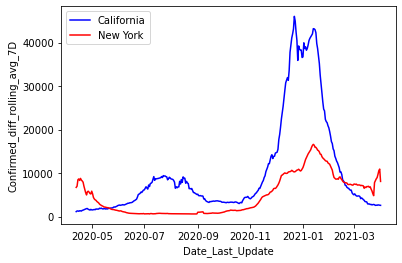

In [51]:
sns.lineplot(data=state_reports['California'], x="Date_Last_Update", y="Confirmed_diff_rolling_avg_7D", color="blue");
sns.lineplot(data=state_reports['New York'], x="Date_Last_Update", y="Confirmed_diff_rolling_avg_7D",color="red");
plt.legend(labels=['California', 'New York']);

In [80]:
state_reports['New Jersey'] = apply_pipeline(load_state_data('New Jersey'))
state_reports['New York'] = apply_pipeline(load_state_data('New York'))
state_reports['California'] = apply_pipeline(load_state_data('California'))

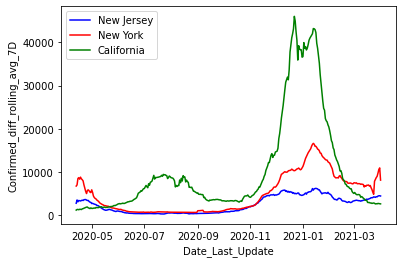

In [81]:
# normalize by population??? 
sns.lineplot(data=state_reports['New Jersey'], x="Date_Last_Update", y="Confirmed_diff_rolling_avg_7D", color="blue");
sns.lineplot(data=state_reports['New York'], x="Date_Last_Update", y="Confirmed_diff_rolling_avg_7D",color="red");
sns.lineplot(data=state_reports['California'], x="Date_Last_Update", y="Confirmed_diff_rolling_avg_7D",color="green");
plt.legend(labels=['New Jersey', 'New York', 'California']);